# Introduction
---
[Delmarva Power & Light](https://en.wikipedia.org/wiki/Delmarva_Power) (DPL) is an electricity and natural gas utility headquartered in Wilmington, Deleware.  Their service areas extend throughout much of Deleware and Maryland's Eastern Shore with over 500,000 electric customers.

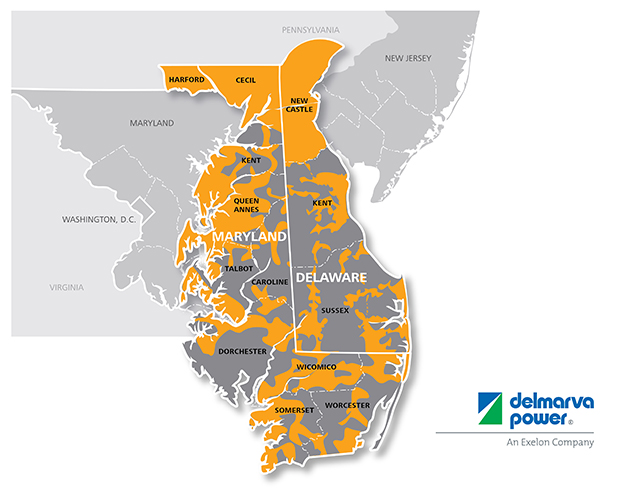

In [1]:
from IPython.display import Image
Image(url='https://www.delmarva.com/SiteCollectionImages/Service%20Area%20Map.jpg', embed=True)

Load profile data represents "average" hourly electricity usage in kilowatt-hours (KWh) for segments of customers.  These segments are typically based on the customer type (e.g. Residential, Commercial, Industrial) and magnitude of usage measured by either annual KWh or maximum usage at a given time (demand).  This data is often provided by utilities and is used by Load Serving Entities (LSEs) to develop hourly estimates of customer usage when only monthly metered usage data is available.

This notebook and the next examine a sample of their load profile data.

# Requirements
---
- Python 3.  Developed with Python 3.6.4, but *should* be fine with any version after 3.4.
- `delmarva_load_profiles.py` : A user-built module that acts as an API to download and parse load profile data.
- `delmarva_lp_code_mapping.csv` : A list of codes used by *delmarva_load_profiles* module in working environment.

The easiest way to run these notebooks would be to download the latest version of [Anaconda](https://www.anaconda.com/download/) and open them using [Jupyter](http://jupyter.org/).

# Notes
---
* All days have 24 observations.  The two Hour 2 observations on Fall Daylight Saving Time transition dates are summed, unless otherwise specified.
* *delmarva_load_profiles* module has not been tested extensively.

# References
---
* [Delmarva Home Page](https://www.delmarva.com)
* [Delmarva Class Load Profile Info](http://www.pepcoholdings.com/library/templates/interior.aspx?pageid=6442454556)

In [2]:
from datetime import date
import os
import pandas as pd
import numpy as np
from delmarva_load_profiles import Delmarva

# Download Sample of Load Profile Data from Delmarva Website for Last Year
The data come in tabular format with hourly observations as columns and segment and date attributes as rows.

In [3]:
def retrieve_data(force_download=False, file_name='delmarva_data.h5', series_name='raw'):
    """Pull data stored on disk or from website (and save a copy)."""
    assert series_name in ('raw', 'lp_tidy')
    if force_download:
        dpl = Delmarva()
        end_date = date.today() - pd.Timedelta(2, 'D')
        start_date = end_date - pd.Timedelta(364, 'D')
        print('Downloading all available Delaware and Maryland data '
              'for {:%b %d, %Y} to {:%b %d, %Y}...\n'
              .format(start_date, end_date))
        df = dpl.get_lp_data(start_date, end_date)
        df.to_hdf(file_name, key='raw_{:%Y%m%d}'.format(date.today()))
        return df
    else:
        if os.path.exists(file_name):
            with pd.HDFStore(file_name, mode='r+') as store:
                key = sorted([key for key in store.keys() 
                              if key.startswith('/' + series_name)], 
                             reverse=True)[0]
                print('Retrieved {} from disk.\n'.format(key[1:]))
                return store[key]
        else:
            return retrieve_data(force_download=True)
                
lp = retrieve_data()
lp.head()

Retrieved raw_20180209 from disk.



,segment,date,H01,H02,H03,H04,H05,H06,H07,H08,...,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
0,DEDGD,2017-02-08,7.09,6.75,6.66,6.56,6.65,7.10,7.79,8.47,...,10.59,10.40,10.34,9.62,9.87,9.96,9.51,8.58,7.75,7.28
1,DEDGL,2017-02-08,52.63,51.31,48.84,50.11,53.42,57.30,64.33,69.24,...,83.07,83.39,79.97,76.08,76.40,73.32,68.13,58.22,55.94,53.58
2,DEDGN,2017-02-08,0.79,0.77,0.76,0.76,0.76,0.75,0.81,0.76,...,0.86,0.87,0.89,0.82,0.83,0.85,0.80,0.77,0.75,0.74
3,DEDGP,2017-02-08,30.60,30.23,29.76,29.49,29.80,31.05,34.12,34.70,...,38.46,37.51,35.52,35.47,38.74,38.71,37.39,34.50,32.00,30.65
4,DEDGS,2017-02-08,3.24,3.10,3.06,3.02,3.05,3.22,3.50,3.74,...,4.65,4.58,4.56,4.23,4.37,4.40,4.18,3.80,3.47,3.27


# Check Data Quality

### Check Data Types and Number of Observations

In [4]:
lp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5536 entries, 0 to 5535
Data columns (total 26 columns):
segment    5536 non-null object
date       5536 non-null datetime64[ns]
H01        5536 non-null float64
H02        5536 non-null float64
H03        5536 non-null float64
H04        5536 non-null float64
H05        5536 non-null float64
H06        5536 non-null float64
H07        5536 non-null float64
H08        5536 non-null float64
H09        5536 non-null float64
H10        5536 non-null float64
H11        5536 non-null float64
H12        5536 non-null float64
H13        5536 non-null float64
H14        5536 non-null float64
H15        5536 non-null float64
H16        5536 non-null float64
H17        5536 non-null float64
H18        5536 non-null float64
H19        5536 non-null float64
H20        5536 non-null float64
H21        5536 non-null float64
H22        5536 non-null float64
H23        5536 non-null float64
H24        5536 non-null float64
dtypes: datetime64[ns](1), fl

## Check for Duplicates
There should be unique observations by day and segment.

In [5]:
dups = lp.duplicated(subset=['segment', 'date'], keep=False)
print('{:.0f} duplicates'.format(dups.sum()/2))

75 duplicates


### Which days and segments are duplicated?

In [6]:
lp[dups].groupby(['date', 'segment']).size().unstack().rename(index=lambda dt: dt.strftime('%b %d, %Y'))

segment,DEDGD,DEDGL,DEDGN,DEDGP,DEDGS,DEDOL,DEDRH,DEDRS,MDDGL,MDDGP,MDDGS,MDDOL,MDDRH,MDDRS,MDDTN
date,,,,,,,,,,,,,,,
"Sep 12, 2017",2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
"Sep 13, 2017",2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
"Sep 14, 2017",2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
"Sep 15, 2017",2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
"Sep 16, 2017",2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


It's not clear why there are duplicates.  The observations may be duplicated on the source website or there may be a bug in the extraction code.  Regardless, we're just going to remove them so we can look at the data.

### Remove Duplicates

In [7]:
lp.drop_duplicates(subset=['segment', 'date'], inplace=True)
lp.shape

(5461, 26)

## Check for Missing Values
Dates ***should*** be continuous and observations should be available for ***all*** segments found in this sample.

### Fill in null records for missing observations

In [8]:
rng = pd.date_range(lp.date.min(), lp.date.max())
segments = lp.segment.unique()
idx = pd.MultiIndex.from_product([segments, rng], names=['segment', 'date'])
lp = lp.set_index(['segment', 'date']).reindex(idx)
mask = lp.isnull().any(1)
print('{:.0f} missing observations'.format(mask.sum()))

14 missing observations


### Which days and segments are missing?

In [9]:
(lp[mask]
 .groupby(level=['date', 'segment']).size()
 .unstack()
 .reindex(columns=segments)
 .rename(index=lambda dt: dt.strftime('%b %d, %Y'))).style.highlight_null('#EC407A')

segment,DEDGD,DEDGL,DEDGN,DEDGP,DEDGS,DEDOL,DEDRH,DEDRS,MDDGL,MDDGP,MDDGS,MDDOL,MDDRH,MDDRS,MDDTN
date,,,,,,,,,,,,,,,
"Jun 24, 2017",1,1,1,1,1,nan,1,1,1,1,1,nan,1,1,nan
"Nov 02, 2017",nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan
"Nov 03, 2017",nan,nan,nan,nan,nan,nan,nan,nan,1,nan,nan,nan,nan,nan,nan


### (Linearly) Interpolate Missing Values by Profile
For each segment, linearly interpolate observations between missing days.  This provides a more accurate representation when aggregating the data. 

In [10]:
lp_interpolated = (lp
                   .groupby(level='segment')
                   .transform(lambda frame: frame.interpolate()))
lp_interpolated['interpolated'] = mask
lp_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5475 entries, (DEDGD, 2017-02-08 00:00:00) to (MDDTN, 2018-02-07 00:00:00)
Data columns (total 25 columns):
H01             5475 non-null float64
H02             5475 non-null float64
H03             5475 non-null float64
H04             5475 non-null float64
H05             5475 non-null float64
H06             5475 non-null float64
H07             5475 non-null float64
H08             5475 non-null float64
H09             5475 non-null float64
H10             5475 non-null float64
H11             5475 non-null float64
H12             5475 non-null float64
H13             5475 non-null float64
H14             5475 non-null float64
H15             5475 non-null float64
H16             5475 non-null float64
H17             5475 non-null float64
H18             5475 non-null float64
H19             5475 non-null float64
H20             5475 non-null float64
H21             5475 non-null float64
H22             5475 non-null float64
H23   

#### Double check the number of interpolated values

In [11]:
lp_interpolated.interpolated.value_counts()

False    5461
True       14
Name: interpolated, dtype: int64

# Transform for Plotting
Now that we have a clean data set, let's parse out some attributes and reshape it for easier visualization.  Combined with information from Delarmarva's website, much information can be gleaned from the segments and the dates.

## Parsed Attributes
* **hour** : Hour of the day (1 - 24).  Represents the interval ending at that number, i.e. 1 is midnight to 1 AM, 2 is 1:01 AM to 2 AM, ..., 24 is 11:00 PM to midnight of the next day.
* **day** : Weekday name (Sunday, Monday, ..., Saturday).
* **date_label** : *Month day* formatted date.
* **state** : US state (MD or DE).
* **profile** : Two character code for specific load profile.
* **profile_name** : More descriptive name for profile from utility.
* **customer_type** : Type of customer (Residential, Commercial, Other).
* **season** : Season of the year, e.g. summer (defined as Jun 16 - Sep 15).

#### Segment Mappings

In [12]:
profiles = {'RS': 'Residential Service', 'RH': 'Residential Heating', 
            'GS': 'Small General Service', 'GL': 'Large General Service', 
            'GP': 'General Service, Primary', 'GT': 'General Service - Transmission', 
            'OL': 'Outdoor Lighting', 'TN': 'Telecommunication Network Service',
            'GD': 'General Service', 'GN': 'General Service - Other'}

customer_types = {'G': 'Commercial', 'R': 'Residential', 'O': 'Other',
                  'T': 'Other'}

#### Reshape with Hours by Row
[Tidy Data](http://vita.had.co.nz/papers/tidy-data.html) is the best format for our purposes here.

In [13]:
lp_tidy = (lp_interpolated
           .reset_index()
           .melt(['segment', 'date', 'interpolated'], 
                 var_name='hour', 
                 value_name='load'))

#### Add attributes

In [14]:
def get_season(dt):
    """
    Get season of the year (winter, summer, spring, fall) for a given date.
    
    
    winter : December 16 - March 15
    spring : March 16 - June 15
    summer : June 16 - September 15
    fall.  : September 16 - December 15
    """
    d = pd.Timestamp(dt)
    yr = d.year
    dx = d.replace(year=yr-1, month=12, day=16)
    dy = d.replace(month=2, day=15)
    mo3 = pd.Timedelta(3, 'M')
    for i, season in enumerate(['winter', 'spring', 'summer', 'fall']):
        if dx <= d <= dy:
            return season
        else:
            dx += mo3
            dy += mo3
    else:
        return 'winter'

In [15]:
lp_tidy['season'] = lp_tidy.date.transform(get_season)
lp_tidy['hour'] = lp_tidy.hour.str.slice(start=1).astype('int')
lp_tidy['day'] = lp_tidy.date.dt.weekday_name
lp_tidy['date_label'] = lp_tidy.date.dt.strftime('%b %d')
lp_tidy['state'] = lp_tidy.segment.str.slice(stop=2)
lp_tidy['profile'] = lp_tidy.segment.str.slice(start=-2)
lp_tidy['profile_name'] = lp_tidy.profile.map(profiles)
lp_tidy['customer_type'] = lp_tidy.profile.transform(lambda x: customer_types[x[0]])

In [16]:
lp_tidy.head(10)

,segment,date,interpolated,hour,load,season,day,date_label,state,profile,profile_name,customer_type
0,DEDGD,2017-02-08,False,1,7.09,winter,Wednesday,Feb 08,DE,GD,General Service,Commercial
1,DEDGD,2017-02-09,False,1,8.09,winter,Thursday,Feb 09,DE,GD,General Service,Commercial
2,DEDGD,2017-02-10,False,1,9.43,winter,Friday,Feb 10,DE,GD,General Service,Commercial
3,DEDGD,2017-02-11,False,1,9.14,winter,Saturday,Feb 11,DE,GD,General Service,Commercial
4,DEDGD,2017-02-12,False,1,8.70,winter,Sunday,Feb 12,DE,GD,General Service,Commercial
5,DEDGD,2017-02-13,False,1,8.50,winter,Monday,Feb 13,DE,GD,General Service,Commercial
6,DEDGD,2017-02-14,False,1,8.76,winter,Tuesday,Feb 14,DE,GD,General Service,Commercial
7,DEDGD,2017-02-15,False,1,8.87,winter,Wednesday,Feb 15,DE,GD,General Service,Commercial
8,DEDGD,2017-02-16,False,1,9.00,winter,Thursday,Feb 16,DE,GD,General Service,Commercial
9,DEDGD,2017-02-17,False,1,9.17,winter,Friday,Feb 17,DE,GD,General Service,Commercial


### Take an inventory
Number of observations by state and profile.

In [17]:
def highlight_positives(s, bg_color='yellow', font_color='black'):
    """Highlight the positive values in a Series."""
    is_pos = s > 0
    return ['background-color: {bg_color}; color: {font_color}'
            .format(bg_color=bg_color, font_color=font_color) 
            if v else '' for v in is_pos]

def gray_zeros(s):
    """Gray out zero values to reduce emphasis."""
    is_zero = s == 0
    return ['color: #D6DBDF' if v else '' for v in is_zero]

(lp_tidy
 .groupby(['state', 'profile_name', 'customer_type']).size()
 .unstack([2, 1], fill_value=0)
 .sort_index(axis=1)
 .astype('int')
 .style
     .apply(highlight_positives, bg_color='#3498DB', font_color='white')
     .apply(gray_zeros))

### Save Copy of Tidy Data

In [18]:
with pd.HDFStore('delmarva_data.h5') as store:
    key='/lp_tidy_{:%Y%m%d}'.format(date.today())
    if key not in store.keys():
        store[key] = lp_tidy